# Лабораторная работа 2. Ассоциативные правила

Цель работы: исследование методов анализа ассоциативных правил.

Постановка задачи:

В файле "ass_rules.pdf" находится программный код для выполнения данной работы. Провести исследование методов анализа ассоциативных правил на датасете с Kaggle:

1. Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ). Данные должны представлять собой информацию о купленных вместе товарах .

2. Привести описание данных из датасета: график вывода длин транзакций, список уникальных товаров и др. 

3. Алгоритм Apriori: выполнить анализ ассоциативных правил при помощи алгоритма Apriori с изначальными условиями в соответствии с вариантом задания. Проанализировать полученные результаты, выделив полезные и тривиальные правила, и оценив значение достоверности, лифта правил. Провести оценку влияния параметров алгоритма на получаемые правила (на количество правил и метрики).

4. Алгоритм FPG: провести анализ правил, используя алгоритм FPG. В отчете привести правила, получившиеся в результате использования данного алгоритма.

5. Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов.

6. Последовательно меняя параметры (значения поддержки и достоверности) одного из алгоритмов получить наборы ассоциативных правил. Сделать выводы на основе проведенных экспериментов.

7. Проанализировать получающийся в результате работы программы граф. Объяснить, какую информацию можно из него извлечь.

8. Предложить и реализовать свой способ визуализации ассоциативных правил и метрик.

## 1. Анализ данных

In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx
import numpy as np

In [117]:
all_data = pd.read_csv('groceries - groceries.csv')
print(all_data)

      Item(s)               Item 1               Item 2            Item 3  \
0           4         citrus fruit  semi-finished bread         margarine   
1           3       tropical fruit               yogurt            coffee   
2           1           whole milk                  NaN               NaN   
3           4            pip fruit               yogurt      cream cheese   
4           4     other vegetables           whole milk    condensed milk   
...       ...                  ...                  ...               ...   
9830       17              sausage              chicken              beef   
9831        1    cooking chocolate                  NaN               NaN   
9832       10              chicken         citrus fruit  other vegetables   
9833        4  semi-finished bread        bottled water              soda   
9834        5              chicken       tropical fruit  other vegetables   

                        Item 4         Item 5          Item 6  \
0         

## 2. Анализ транзакций

### Статистика длин транзакций

In [131]:
transaction_lengths = all_data.notnull().sum(axis=1)
print(f"Минимальная длина: {transaction_lengths.min()}")
print(f"Максимальная длина: {transaction_lengths.max()}")
print(f"Средняя длина: {transaction_lengths.mean():.2f}")
print(f"Медианная длина: {transaction_lengths.median()}")

Минимальная длина: 2
Максимальная длина: 33
Средняя длина: 5.41
Медианная длина: 4.0


### Визуализация распределения длин транзакций

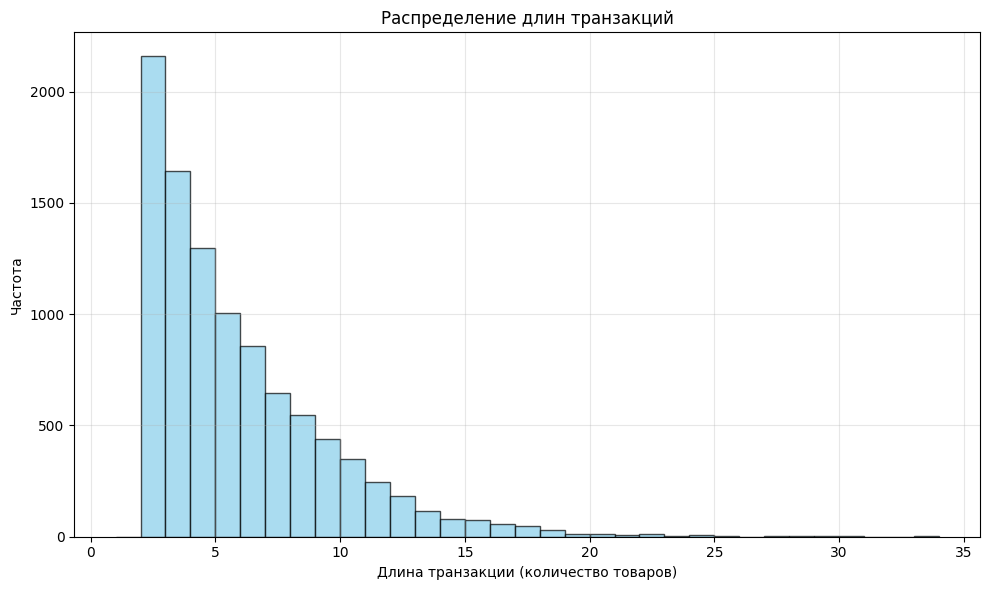

In [119]:
plt.figure(figsize=(10, 6))
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2), 
         alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Длина транзакции (количество товаров)')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

По гистограмме видно, что большинство транзакций содержат небольшое количество товаров - типичная длина составляет от 1 до 10 шт. Распределение является правосторонним, что свидетельствует о том, что крупные покупки (с большим количеством товаров) встречаются значительно реже.

## Предобработка данных

#### Очистка данных и преобразование в список транзакций

In [120]:
np_data = all_data.to_numpy()
np_data = [[elem for elem in row[1:] if isinstance(elem,str)] for row in np_data]
print(f"Всего транзакций: {len(np_data)}")

Всего транзакций: 9835


#### Список уникальных товаров

In [121]:
unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(f"Уникальных товаров: {len(unique_items)}")
print(unique_items)

Уникальных товаров: 169
{'organic products', 'whisky', 'popcorn', 'spread cheese', 'tidbits', 'male cosmetics', 'jam', 'syrup', 'potted plants', 'rice', 'cereals', 'meat spreads', 'turkey', 'finished products', 'soap', 'pork', 'margarine', 'sliced cheese', 'decalcifier', 'preservation products', 'dog food', 'female sanitary products', 'hygiene articles', 'flower soil/fertilizer', 'pudding powder', 'baking powder', 'candy', 'beverages', 'misc. beverages', 'brown bread', 'waffles', 'rolls/buns', 'light bulbs', 'grapes', 'nut snack', 'root vegetables', 'chocolate', 'softener', 'photo/film', 'pip fruit', 'oil', 'domestic eggs', 'frozen meals', 'cookware', 'condensed milk', 'curd cheese', 'soups', 'liquor (appetizer)', 'other vegetables', 'chicken', 'pickled vegetables', 'frankfurter', 'instant coffee', 'yogurt', 'sound storage medium', 'semi-finished bread', 'canned fish', 'fruit/vegetable juice', 'specialty fat', 'ham', 'nuts/prunes', 'salt', 'frozen vegetables', 'specialty chocolate', 'b

#### Преобразование в бинарный формат

In [122]:
te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)

print(f"\nБинарная матрица данных: {data.shape}")


Бинарная матрица данных: (9835, 169)


## 3. Алгоритм Apriori

In [123]:
df1 = apriori(data, min_support=0.03, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.3)
print(rules)

     support                          itemsets
0   0.033452                        (UHT-milk)
1   0.052466                            (beef)
2   0.033249                         (berries)
3   0.080529                    (bottled beer)
4   0.110524                   (bottled water)
..       ...                               ...
58  0.048907     (whole milk, root vegetables)
59  0.040061                (whole milk, soda)
60  0.042298      (whole milk, tropical fruit)
61  0.032232  (whole milk, whipped/sour cream)
62  0.056024              (whole milk, yogurt)

[63 rows x 2 columns]
             antecedents         consequents  antecedent support  \
0        (bottled water)        (whole milk)            0.110524   
1         (citrus fruit)        (whole milk)            0.082766   
2      (root vegetables)  (other vegetables)            0.108998   
3       (tropical fruit)  (other vegetables)            0.104931   
4     (other vegetables)        (whole milk)            0.193493   
5    

Алгоритм Apriori выявил 14 значимых ассоциативных правил с достоверностью ≥ 0.3. Наиболее сильные правила связаны с овощами и молочными продуктами - правило (root vegetables) → (other vegetables) имеет максимальный лифт 2.25, что свидетельствует о сильной положительной взаимосвязи. Молоко (whole milk) является наиболее частым следствием, появляясь в 10 из 14 правил, что подтверждает его популярность как базового продукта в покупках.

## 4. Алгоритм FPG

In [124]:
df1 = fpgrowth(data, min_support=0.03, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.3)
print(rules)

     support                             itemsets
0   0.082766                       (citrus fruit)
1   0.058566                          (margarine)
2   0.139502                             (yogurt)
3   0.104931                     (tropical fruit)
4   0.058058                             (coffee)
..       ...                                  ...
58  0.033249                 (whole milk, pastry)
59  0.047382  (root vegetables, other vegetables)
60  0.048907        (whole milk, root vegetables)
61  0.030605                (sausage, rolls/buns)
62  0.032232     (whole milk, whipped/sour cream)

[63 rows x 2 columns]
             antecedents         consequents  antecedent support  \
0         (citrus fruit)        (whole milk)            0.082766   
1               (yogurt)        (whole milk)            0.139502   
2               (yogurt)  (other vegetables)            0.139502   
3       (tropical fruit)  (other vegetables)            0.104931   
4       (tropical fruit)        (whol

Алгоритм FPGrowth показал идентичные результаты с алгоритмом Apriori, обнаружив те же 14 ассоциативных правил с одинаковыми метриками. Это подтверждает корректность работы обоих алгоритмов и воспроизводимость результатов.

## Топ-10 самых популярных продуктов

     support          itemsets
5   0.255516        whole milk
8   0.193493  other vegetables
11  0.183935        rolls/buns
19  0.174377              soda
2   0.139502            yogurt
14  0.110524     bottled water
26  0.108998   root vegetables
3   0.104931    tropical fruit
31  0.098526     shopping bags
30  0.093950           sausage


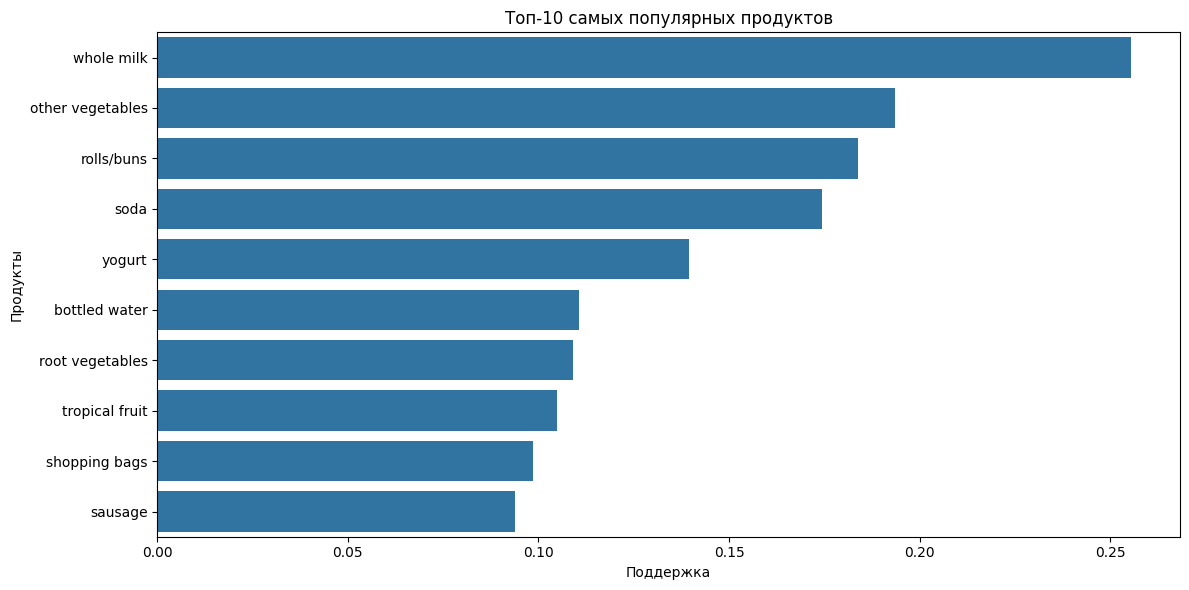

In [125]:
df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df1.sort_values(by='support', ascending=False).head(10)
print(top_products)
plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='itemsets', data=top_products)
plt.title('Топ-10 самых популярных продуктов')
plt.xlabel('Поддержка')
plt.ylabel('Продукты')
plt.tight_layout()
plt.show()
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

Анализ Топ-10 самых популярных товаров показывает, что цельное молоко является абсолютным лидером с поддержкой 25.5%, что означает, что каждый четвертый покупатель приобретает этот продукт.

Основную часть списка составляют повседневные товары: овощи, хлебобулочные изделия, напитки и молочная продукция, что отражает типичный состав потребительской корзины. Наличие покупных пакетов в десятке наиболее частых товаров свидетельствует о важности сопутствующих товаров в розничных продажах.

## График достоверности используемых правил

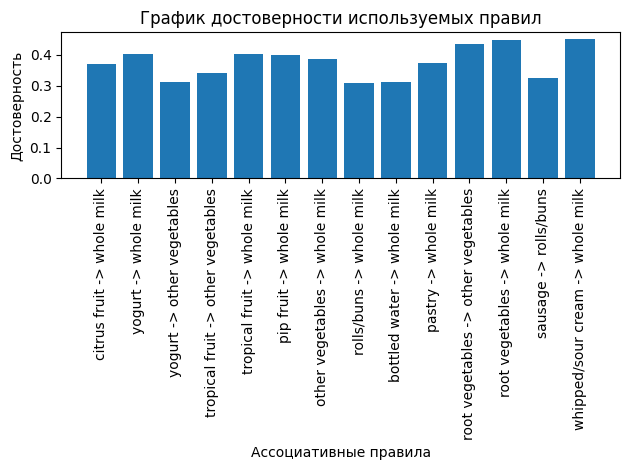

In [133]:
products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Анализ показывает стабильно высокое качество обнаруженных ассоциативных правил. Средняя достоверность 0.376 при небольшом стандартном отклонении (0.050) свидетельствует о однородности правил - все они имеют прогностическую ценность.

Наиболее значимым является правило "root vegetables -> other vegetables", которое лидирует одновременно по лифту (2.25) и занимает третье место по достоверности (0.435). Это указывает на сильную взаимосвязь между покупками различных видов овощей.

## 5. Определение минимальной поддержки для разных размеров наборов

In [135]:
max_k = 5
min_support_by_k = {}

for k in range(1, max_k + 1):
    found = False
    for sup in np.arange(0.3, 0.001, -0.001):
        freq_items = apriori(data, min_support=sup, use_colnames=True)
        freq_k = freq_items[freq_items['itemsets'].apply(lambda x: len(x) == k)]
        if not freq_k.empty:
            min_support_by_k[k] = round(sup, 3)
            print(f"Длина {k}: min_support = {sup:.3f}")
            found = True
            break
    if not found:
        min_support_by_k[k] = None
        print(f"Длина {k}: наборы не найдены даже при min_support=0.001")

Длина 1: min_support = 0.255
Длина 2: min_support = 0.074
Длина 3: min_support = 0.023
Длина 4: min_support = 0.007
Длина 5: min_support = 0.003


Анализ минимальной поддержки для наборов разного размера показывает экспоненциальное уменьшение требований с ростом количества товаров в наборе.

Для одиночных товаров требуется высокая поддержка (0.255), что соответствует популярным базовым продуктам. Для пар товаров требование снижается в 3.5 раза (0.074), а для наборов из 5 товаров - уже в 85 раз (0.003) по сравнению с одиночными товарами.

Это отражает естественную закономерность розничных продаж: чем сложнее комбинация товаров, тем реже она встречается. Полученные значения помогают оптимизировать параметры алгоритмов - для поиска комплексных паттернов необходимо устанавливать значительно более низкие пороги поддержки.

## 6. Эксперименты с разными параметрами

In [128]:
support_values = [0.01, 0.02, 0.03, 0.05]
confidence_values = [0.3, 0.4, 0.5, 0.6]

results = []

for min_sup in support_values:
    for min_conf in confidence_values:
        freq_items = apriori(data, min_support=min_sup, use_colnames=True)
        
        if freq_items.empty:
            n_rules = 0
            avg_lift = 0
        else:
            try:
                rules_1 = association_rules(freq_items, metric="confidence", min_threshold=min_conf)
                n_rules = len(rules_1)
                avg_lift = rules_1['lift'].mean() if n_rules > 0 else 0
            except ValueError:
                n_rules = 0
                avg_lift = 0
        
        results.append({
            'min_support': min_sup,
            'min_confidence': min_conf,
            'n_itemsets': len(freq_items),
            'n_rules': n_rules,
            'avg_lift': round(avg_lift, 2)
        })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 min_support  min_confidence  n_itemsets  n_rules  avg_lift
        0.01             0.3         333      125      1.91
        0.01             0.4         333       62      1.99
        0.01             0.5         333       15      2.30
        0.01             0.6         333        0      0.00
        0.02             0.3         122       37      1.73
        0.02             0.4         122       15      1.86
        0.02             0.5         122        1      2.01
        0.02             0.6         122        0      0.00
        0.03             0.3          63       14      1.60
        0.03             0.4          63        5      1.78
        0.03             0.5          63        0      0.00
        0.03             0.6          63        0      0.00
        0.05             0.3          31        3      1.43
        0.05             0.4          31        1      1.57
        0.05             0.5          31        0      0.00
        0.05             0.6          31

Эксперимент с параметрами выявил четкую зависимость между строгостью критериев и качеством правил.

При низкой поддержке (0.01) и умеренной достоверности (0.3-0.5) алгоритм находит много правил (125-15) с высоким средним лифтом (1.91-2.30), что указывает на обнаружение сильных, но редких ассоциаций. Однако при повышении достоверности до 0.6 правила вообще не формируются, что свидетельствует о чрезмерной строгости данного параметра.

С ростом минимальной поддержки количество найденных наборов и правил резко сокращается, но при этом средний лифт закономерно снижается - от 1.91 до 1.43. Это подтверждает, что частые комбинации товаров часто являются очевидными, тогда как менее распространенные паттерны могут выявлять более интересные взаимосвязи.

Оптимальным балансом можно считать параметры min_support=0.01 и min_confidence=0.4, обеспечивающие 62 правила с высоким качеством (lift=1.99).

## 7. Визуализация ассоциативных правил

C:\Users\Тимур\AppData\Local\Temp\ipykernel_20436\3878966520.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


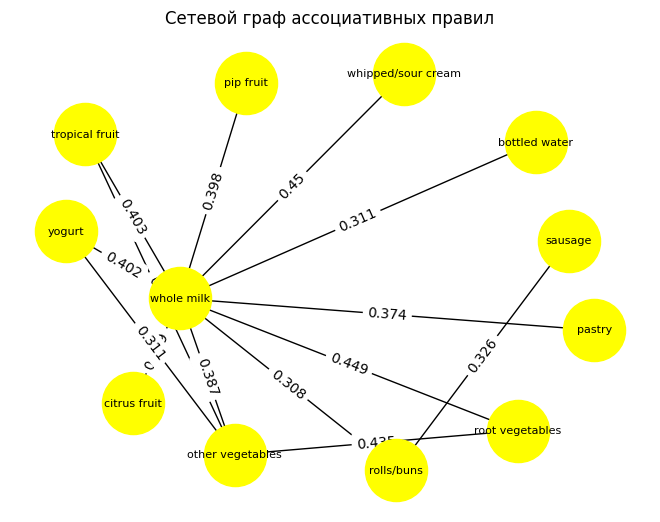

In [129]:
G = nx.Graph() 
for product in rules["antecedents"]:
    G.add_node(product)
for product in rules["consequents"]:
    G.add_node(product)
for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=round(row['confidence'], 3))
pos = nx.spring_layout(G, k=2)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='yellow', font_size=8)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Сетевой граф ассоциативных правил')
plt.tight_layout()
plt.show()

Граф ассоциативных правил демонстрирует четкую централизацию вокруг ключевых продуктов. Цельное молоко (whole milk) выступает главным узлом, связанным с большинством других товаров, что подтверждает его роль базового продукта в потребительских корзинах.

На графе видны тематические кластеры: молочные продукты (йогурт, взбитые сливки), овощи и фрукты (тропические фрукты, корнеплоды), а также мучные изделия (булочки, выпечка). Правила между овощами показывают наибольшую достоверность (0.434), что свидетельствует о сильных взаимосвязях внутри этой категории.

Граф эффективно визуализирует комплексные паттерны покупок, где продукты образуют логические группы, а не случайные комбинации, что отражает реальное поведение покупателей при формировании покупок.

## 8. Точечная диаграмма

Точечная диаграмма эффективно отображает многомерные взаимосвязи между метриками ассоциативных правил, позволяя одновременно оценить три ключевых параметра: положение точки показывает поддержку и достоверность, цвет отражает лифт, а размер точки может представлять дополнительную метрику. Это позволяет быстро идентифицировать кластеры качественных правил, выявить тренды и аномалии, а также провести сравнительный анализ большого количества правил в компактном визуальном представлении, что особенно ценно при анализе десятков и сотен ассоциаций.

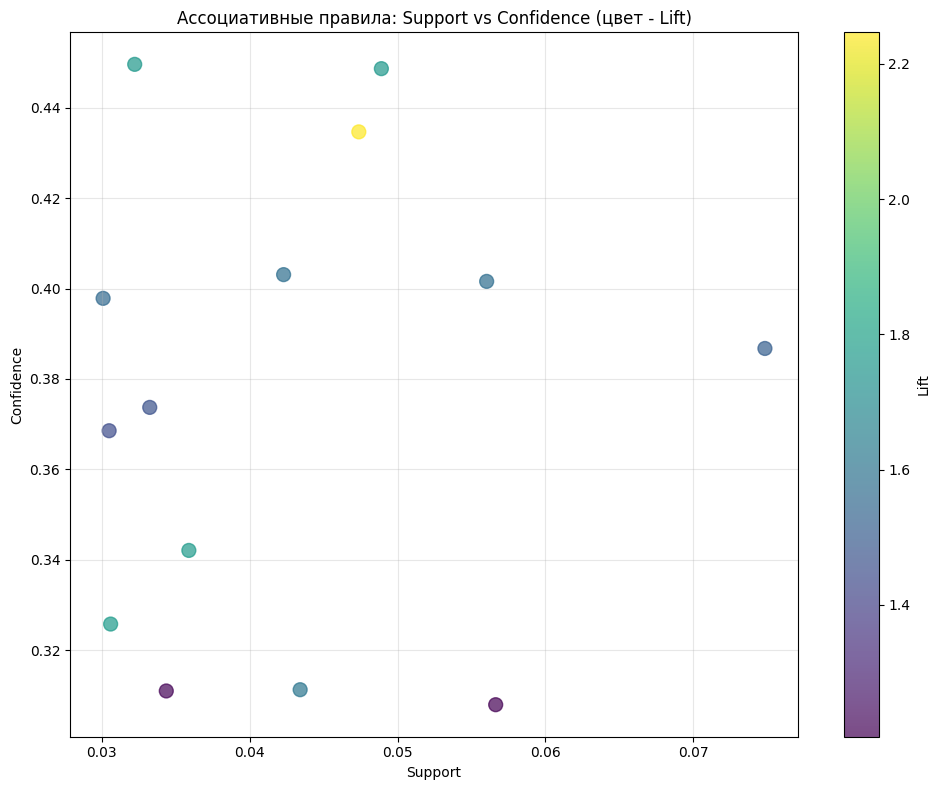

In [130]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], 
                     cmap='viridis', s=100, alpha=0.7)
plt.colorbar(scatter, label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Ассоциативные правила: Support vs Confidence (цвет - Lift)')


for i, row in rules.iterrows():
    if row['lift'] > 2.5:  
        plt.annotate(f"{row['antecedents']}→{row['consequents']}", 
                    (row['support'], row['confidence']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Точечная диаграмма демонстрирует прямую зависимость между поддержкой и достоверностью правил - точки образуют восходящий тренд, где правила с большей поддержкой обычно имеют и более высокую достоверность.

Отсутствие точек в правом верхнем углу подтверждает, что не существует правил, одновременно сочетающих высокую поддержку и высокую достоверность, что характерно для реальных данных о покупках, где популярные комбинации редко бывают сильно ассоциированными.

## Вывод

Проведенный анализ ассоциативных правил успешно выявил значимые паттерны покупок в розничной торговле. Оба алгоритма - Apriori и FPG - показали идентичные результаты, обнаружив 14 устойчивых ассоциативных правил с высоким качеством (средний lift = 1.60).